In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

### Layer-wise recovery curves

In [2]:
# 1) Load all CSVs into one DataFrame
# files = glob.glob("*_[0-9].csv")  # e.g. en_0.csv, en_1.csv, …
files = glob.glob("window3/*[1-5].csv")
dfs   = [pd.read_csv(f) for f in files]
df    = pd.concat(dfs, ignore_index=True)

In [3]:
def gold_logp(series, logp_list_col):
    return df.apply(lambda row: row[logp_list_col][ row['gold_idx'] ], axis=1)

In [4]:
# get scalar log‐probs
df = df.copy()
# elements are string representations of lists, parse them
df['logp_corrupt_list'] = df['logp_corrupt_list'].apply(ast.literal_eval)
df['logp_restored_list'] = df['logp_restored_list'].apply(ast.literal_eval)

df['logp_corrupt_gold'] = gold_logp(df, 'logp_corrupt_list')
df['logp_restored_gold'] = gold_logp(df, 'logp_restored_list')

# convert to joint probabilities
df['p_corrupt']  = np.exp(df['logp_corrupt_gold'])
df['p_restored'] = np.exp(df['logp_restored_gold'])

# recompute delta in probability space
df['delta_restored'] = df['p_restored'] - df['p_corrupt']

# (optional) drop intermediate columns if you like
df = df.drop(columns=[
    'logp_corrupt_gold', 'logp_restored_gold'
])

In [5]:
# (a) First collapse over prompt_id, so we average δp per (language,stream,layer,tense,seed)
group = (
    df
    .groupby(["language","stream","restore_layer","tense","noise_seed","prompt_id"])
    ["delta_restored"]
    .max()
    .reset_index()
)

# (b) Compute mean and SEM of δp over noise_seed for each (language,stream,layer,tense)
stats = (
    group
    .groupby(["language","stream","restore_layer","tense"])["delta_restored"]
    .agg(
        mean   = "mean",
        sem    = lambda x: x.std(ddof=1) / np.sqrt(len(x))
    )
    .reset_index()
)

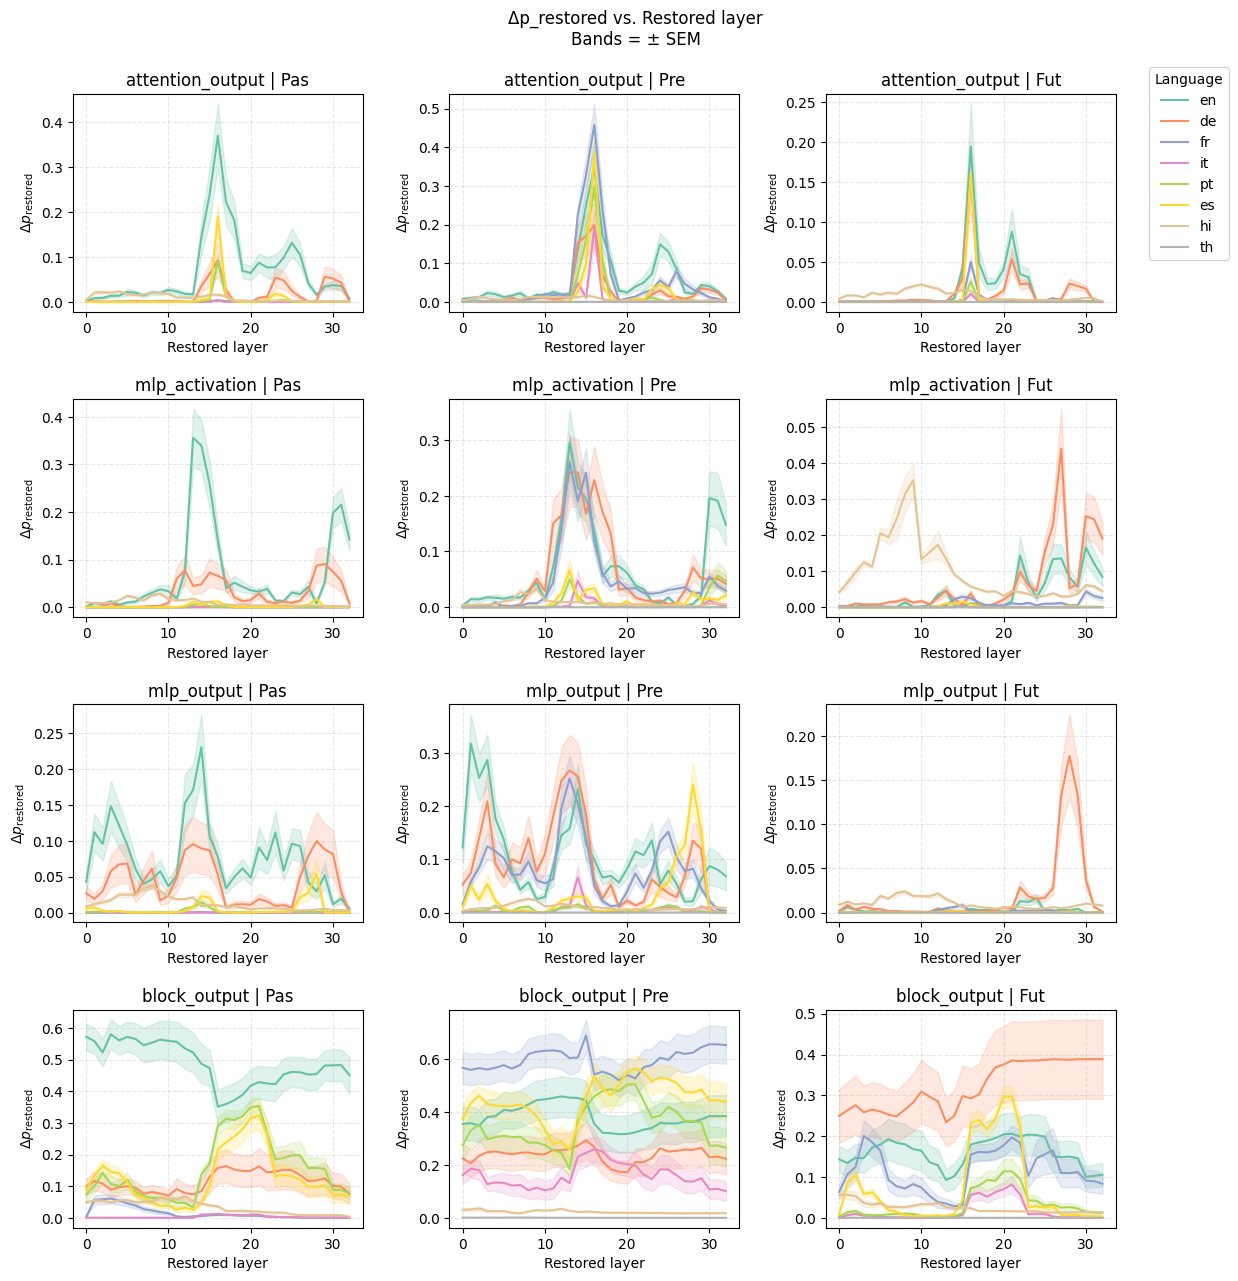

In [6]:
lang_order = ["en","de","fr","it","pt","es","hi","th"]
palette   = dict(zip(lang_order, sns.color_palette("Set2", n_colors=len(lang_order))))

streams = ["attention_output", "mlp_activation", "mlp_output", "block_output"]        # e.g. ["attention_output", "mlp_activation", ...]
tenses  = ["pas", "pre", "fut"]
# ylim = [0.6, 0.5, 0.5, 1.0]

n_rows = len(streams)
n_cols = len(tenses)
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(5 * n_cols, 3.5 * n_rows),
    sharey=False
)

# If there's only one row or column, make axes 2D for consistency
if n_rows == 1:
    axes = np.expand_dims(axes, axis=0)
if n_cols == 1:
    axes = np.expand_dims(axes, axis=1)

# ─── DRAW LINES AND BANDS INLINE ───────────────────────────────────────────────
for i, stream in enumerate(streams):
    for j, tense in enumerate(tenses):
        ax = axes[i][j]
        sub = stats[(stats["stream"] == stream) & (stats["tense"] == tense)]
        
        # For each language, plot mean ± SEM vs. restore_layer
        for lang in lang_order:
            sl = sub[sub["language"] == lang].sort_values("restore_layer")
            if sl.empty:
                continue
            x = sl["restore_layer"]
            y = sl["mean"]
            se = sl["sem"]
            
            ax.plot(
                x, y,
                label=lang,
                color=palette[lang]
            )
            ax.fill_between(
                x,
                y - se,
                y + se,
                alpha=0.2,
                color=palette[lang]
            )
            
#         ax.set_ylim(0.0, ylim[i])
        ax.set_title(f"{stream} | {tense.capitalize()}")
        ax.set_xlabel("Restored layer")
        ax.set_ylabel(r"$\Delta p_{\mathrm{restored}}$")
        ax.grid(True, linestyle='--', alpha=0.3)

# ─── ADD LEGEND ───────────────────────────────────────────────────────────────
# Place a single legend outside on the right
handles, labels = axes[0][1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Language",
    bbox_to_anchor=(0.9, 0.87),
    loc="center right"
)

plt.subplots_adjust(
    top=0.92,
    right=0.82,
    hspace=0.4,
    wspace=0.3
)
fig.suptitle("Δp_restored vs. Restored layer\nBands = ± SEM", y=0.98)
plt.show()

### Tense Bias

In [7]:
# 1) Find peak layer per (lang,tense,prompt_id,noise_seed,stream)
peaks = (
    df
    .groupby(["language","tense","prompt_id","noise_seed","stream"])
    .apply(lambda df: df.loc[df.delta_restored.idxmax(), "restore_layer"])
    .reset_index(name="peak_layer")
)

peaks

/var/tmp/pbs.11563285.pbs-m1.metacentrum.cz/ipykernel_922873/2685498941.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.loc[df.delta_restored.idxmax(), "restore_layer"])


,language,tense,prompt_id,noise_seed,stream,peak_layer
0,de,fut,fut_de1,0,attention_output,16
1,de,fut,fut_de1,0,block_output,0
2,de,fut,fut_de1,0,mlp_activation,30
3,de,fut,fut_de1,0,mlp_output,1
4,de,fut,fut_de1,1,attention_output,16
...,...,...,...,...,...,...
2295,th,pre,pre_th5,3,mlp_output,16
2296,th,pre,pre_th5,4,attention_output,25
2297,th,pre,pre_th5,4,block_output,1
2298,th,pre,pre_th5,4,mlp_activation,14


In [8]:
# summary = (
#     peaks
#     .groupby(["language", "tense", "stream"])["peak_layer"]
#     .agg(mean_peak=("mean"), std_peak=("std"))
#     .reset_index()
# )
# summary['mean_peak'] = summary['mean_peak'].astype(int)
# # summary

summary = (
    peaks
    .groupby(["language", "tense", "stream"])["peak_layer"]
    .agg(
        mean_peak=lambda x: x.value_counts().idxmax(),   # most frequent layer
        std_peak=("std")     # its frequency
    )
    .reset_index()
)
summary

,language,tense,stream,mean_peak,std_peak
0,de,fut,attention_output,16,0.000000
1,de,fut,block_output,0,11.821590
2,de,fut,mlp_activation,27,1.224745
3,de,fut,mlp_output,28,11.022704
4,de,pas,attention_output,16,0.000000
...,...,...,...,...,...
87,th,fut,mlp_output,22,3.593976
88,th,pre,attention_output,14,4.591659
89,th,pre,block_output,6,2.466441
90,th,pre,mlp_activation,16,6.595453


In [9]:
atto = summary[summary['stream'] == 'attention_output']
mlpa = summary[summary['stream'] == 'mlp_activation']
mlpo = summary[summary['stream'] == 'mlp_output']
bloc = summary[summary['stream'] == 'block_output']

stream_dfs = {
    "attention_output": atto,
    "mlp_activation":   mlpa,
    "mlp_output":       mlpo,
    "block_output":     bloc
}

Standard deviation of the peak_layer across noise_seed measures how much the “best” layer fluctuates when we change the noise seed. Concretely, for a fixed (language, tense, prompt_id, stream), you have multiple peak_layer values—one per noise_seed. A low σ means every noise_seed yields nearly the same peak layer—i.e., the layer at which restoration spikes is robust to random initialization. A high σ means different seeds pick different peak layers, so the apparent “best” layer is unstable under noise.

In [10]:
from IPython.display import display
def print_tense_bias_table(stream_df):
    agg = (stream_df.groupby(['language', 'tense']).agg(
        peak_layer=('mean_peak', 'max'),
        std=('std_peak', 'max')
    ))
    agg['std'] = agg['std'].round(2)

    display(agg)

In [11]:
print_tense_bias_table(atto)

peak_layer   std
language tense                  
de       fut            16  0.00
         pas            16  0.00
         pre            16  3.27
en       fut            16  0.00
         pas            16  0.00
         pre            16  1.63
es       fut            16  0.00
         pas            16  0.00
         pre            16  3.67
fr       fut            16  0.00
         pas            16  0.00
         pre            16  0.00
hi       fut            10  2.38
         pas             4  2.66
         pre             8  4.44
it       fut            16  0.00
         pas            16  0.00
         pre            16  0.00
pt       fut            16  0.00
         pas            16  0.00
         pre            16  4.08
th       fut            16  5.00
         pre            14  4.59

In [12]:
print_tense_bias_table(mlpa)

peak_layer    std
language tense                   
de       fut            27   1.22
         pas            13   8.04
         pre            16   8.37
en       fut            30   6.89
         pas            14   8.43
         pre            13   7.08
es       fut            15   1.12
         pas            16   5.28
         pre            29   7.76
fr       fut            30   6.03
         pas            15   5.90
         pre            13   6.19
hi       fut             9   0.50
         pas             8   1.71
         pre             9   1.53
it       fut            15   6.47
         pas            13   6.52
         pre            14   6.03
pt       fut            13   8.34
         pas            29   8.48
         pre            30   8.78
th       fut            31  10.34
         pre            16   6.60

In [13]:
print_tense_bias_table(mlpo)

peak_layer    std
language tense                   
de       fut            28  11.02
         pas             1  10.01
         pre            13   6.87
en       fut            23   0.76
         pas            14   8.89
         pre             1   6.34
es       fut            14   8.13
         pas            14   6.14
         pre            28   1.78
fr       fut            14   6.38
         pas            13   6.41
         pre            13   6.99
hi       fut             5   3.33
         pas             9   0.91
         pre             8   2.10
it       fut            13   9.52
         pas            21   3.50
         pre            29   9.39
pt       fut            14   6.68
         pas            14   9.26
         pre            29   9.25
th       fut            22   3.59
         pre            16   1.22

In [14]:
print_tense_bias_table(bloc)

peak_layer    std
language tense                   
de       fut             0  11.82
         pas            17   7.72
         pre            16   5.35
en       fut             0   8.84
         pas            11   8.10
         pre            30  10.83
es       fut            21   0.50
         pas            21   7.40
         pre             8  10.77
fr       fut             3   9.70
         pas             4   2.45
         pre            12   7.60
hi       fut             0   6.19
         pas            12   4.58
         pre             4   4.94
it       fut            21   8.37
         pas            21   2.69
         pre            14   7.88
pt       fut            22   2.66
         pas            20   3.67
         pre            17   5.42
th       fut             0   9.07
         pre             6   2.47

### Tense-Language cluster (x-axis: delta_prob, y-axis: layers)

Plot the tense bias (one color for each tense, circling around languages, x-axis is layers)
Treat each (language,tense) pair as one point in a high-dimensional “layer-response” space

### Heatmap (prob activation through tokens & layers)

In [15]:
# 1) Compute, for each prompt, the first and last pos
pos_stats = df.groupby("prompt_id")["pos"].agg(
    first_verb_pos="min",
    final_pos="max"
).reset_index()
df = df.merge(pos_stats, on="prompt_id")

In [16]:
def categorize_pos(row):
    p = row['pos']
    if p == 0:
        return '<begin_of_text>'
    elif p == row.first_verb_pos - 1:
        return '<pre_verb>'
    elif row.first_verb_pos <= p <= row.final_pos - 1:
        # everything from first_verb_pos up to just before final_pos
        return '<tense_bearing>'
    elif p == row.final_pos:
        return '<last>'
    else:
        return np.nan    # any other position you don’t care about

# 2) Apply it to your full df
df['pos_cat'] = df.apply(categorize_pos, axis=1)

# 3) Drop any rows where pos_cat is NaN
df = df.dropna(subset=['pos_cat'])

In [17]:
# 2) Global aggregation over language, prompt_id, noise_seed, gold, etc.
#    Compute mean p_restored for each (tense, stream, pos_cat, restore_layer)
agg = (
    df
    .groupby(['tense','stream','pos_cat','restore_layer'])['p_restored']
    .mean()
    .reset_index()
)

In [18]:
# 3) Define the ordering of tenses, streams, and token categories
tense_order   = ['pas','pre','fut']
stream_order  = ['block_output','attention_output','mlp_activation','mlp_output']
pos_cats      = ['<begin_of_text>','<tense_bearing>','<last>']
tense_label   = ['Past', 'Present', 'Future']
# vmax_list     = [0.7, 0.7, 0.4, 0.4]

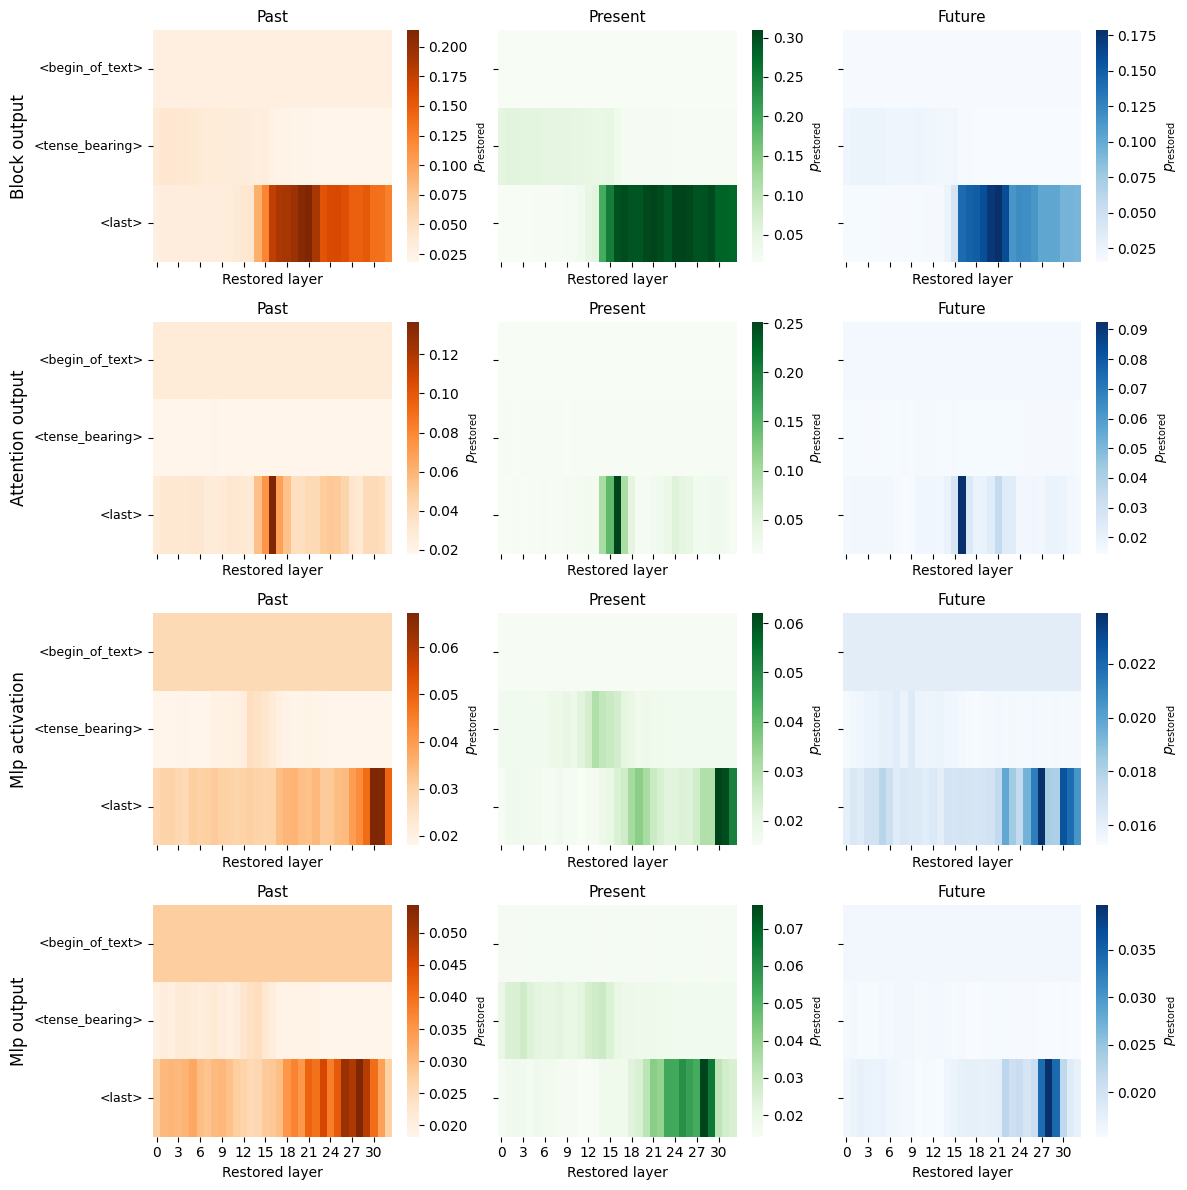

In [19]:
# 4) Set up the subplot grid: 3 rows (tenses) × 4 cols (streams)
fig, axes = plt.subplots(
    ncols=len(tense_order),
    nrows=len(stream_order),
    figsize=(4*len(tense_order), 3*len(stream_order)),
    sharex=True,
    sharey=True
)
cmaps = ["Oranges", "Greens", "Blues"]

# 5) Draw one heatmap per (tense, stream)
for i, stream in enumerate(stream_order):
    for j, tense in enumerate(tense_order):
        ax = axes[i, j]
        sub = agg[(agg.tense == tense) & (agg.stream == stream)]
        # pivot so rows=pos_cat, cols=restore_layer
        heat = sub.pivot(index='pos_cat', columns='restore_layer', values='p_restored')
        # reindex rows to ensure all pos_cats appear in the correct order
        heat = heat.reindex(index=pos_cats)
        sns.heatmap(
            heat,
            ax=ax,
            cmap=cmaps[j],
#             vmin=0.0,
#             vmax=vmax_list[i],
            cbar=True,
#             cbar=(j == len(tense_order)-1),  # only rightmost column gets colorbar
            cbar_kws={'label': r'$p_{\mathrm{restored}}$'}
        )
        # axis labels & titles
        if j == 0:
            ax.set_ylabel(stream.capitalize().replace('_',' '), fontsize=12)
        else:
            ax.set_ylabel('')
        ax.set_xlabel('Restored layer', fontsize=10)
        ax.set_title(tense_label[j], fontsize=11)
        # ensure y-tick labels show each pos_cat
        ax.set_yticks(np.arange(len(pos_cats))+0.5)
        ax.set_yticklabels(pos_cats, rotation=0, fontsize=9)

fig.tight_layout()
plt.show()

In [20]:
agg = (
    df
    .groupby(["language","tense","stream","restore_layer","noise_seed","prompt_id"])
    ["p_restored"]
    .max()
    .reset_index()
    .groupby(["language","tense","stream","restore_layer"])
    ["p_restored"]
    .mean()
    .reset_index(name="p_restored_mean")
)

agg2 = (
    agg
    .groupby(["tense","stream","restore_layer"])
    ["p_restored_mean"]
    .mean()
    .reset_index(name="p_restored_mean")
)

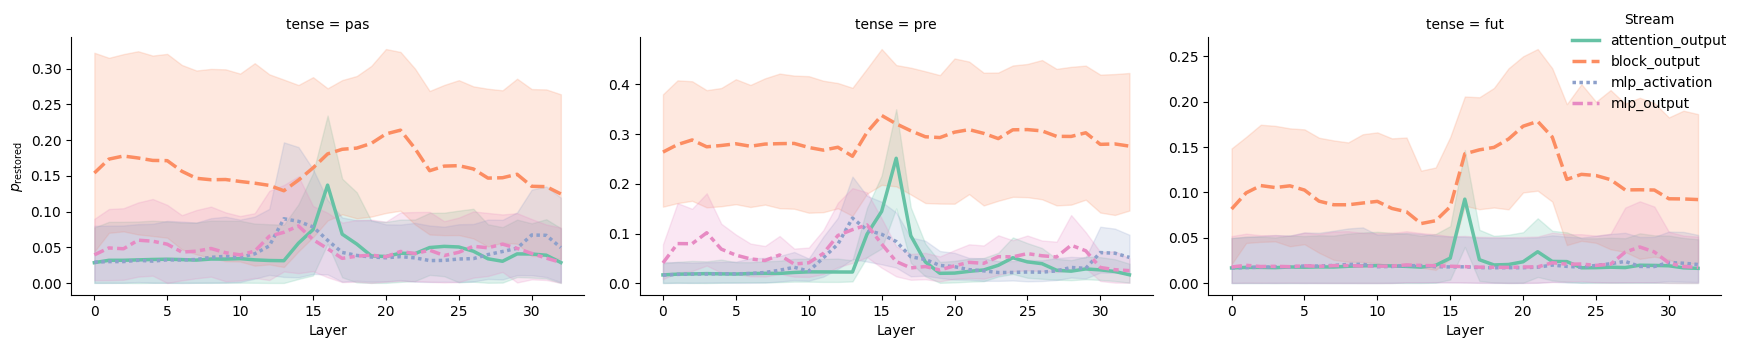

In [21]:
tense_order = ['pas', 'pre', 'fut']
df['tense'] = pd.Categorical(df['tense'],
                             categories=tense_order,
                             ordered=True)

# 2) decide per-language y-limits, e.g. compute the overall max delta_restored per language
ymax_per_lang = (
    df
    .groupby('language')['p_restored']
    .mean()
    .to_dict()
)

# 3) build the FacetGrid with sharey=False
g = sns.FacetGrid(
    data=agg,
#     row="language",
    col="tense",
    row_order=list(ymax_per_lang.keys()),   
    col_order=tense_order,                  # fixed tense order
    sharex=True,
    sharey=False,                           # allow each row its own y-axis
    height=3.5,
    aspect=1.5
)

# 4) map your lineplot
g.map_dataframe(
    sns.lineplot,
    x="restore_layer", y="p_restored_mean",
    hue="stream", style="stream",
    palette="Set2", linewidth=2.5
)
g.add_legend(title="Stream")
sns.move_legend(g, "upper right")
g.set_axis_labels("Layer", r"$p_{\mathrm{restored}}$")

plt.tight_layout()
plt.show()

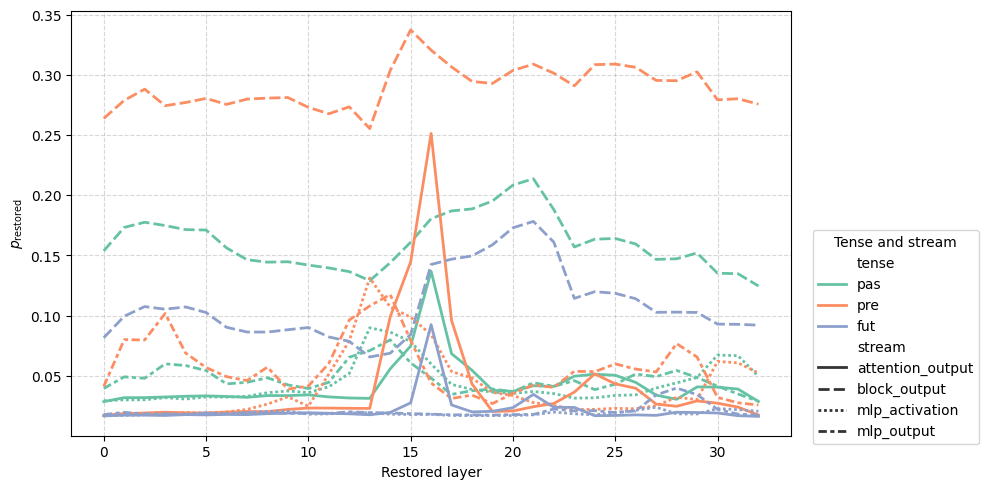

In [22]:
tense_order = ['pas', 'pre', 'fut']
df['tense'] = pd.Categorical(df['tense'],
                             categories=tense_order,
                             ordered=True)

# 2) decide per-language y-limits, e.g. compute the overall max delta_restored per language
ymax_per_lang = (
    df
    .groupby('language')['p_restored']
    .mean()
    .to_dict()
)

palette = sns.color_palette("Set2", n_colors=len(tense_order))

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=agg,
    x="restore_layer",
    y="p_restored_mean",
    hue="tense",
    hue_order=tense_order,
    style="stream",
    palette='Set2',
    linewidth=2, 
    errorbar=None
)
plt.xlabel("Restored layer")
plt.ylabel(r"$p_{\mathrm{restored}}$")
# plt.title("Direct transfer performance vs. Layer")
plt.legend(title="Tense and stream", bbox_to_anchor=(1.02, 0.5))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

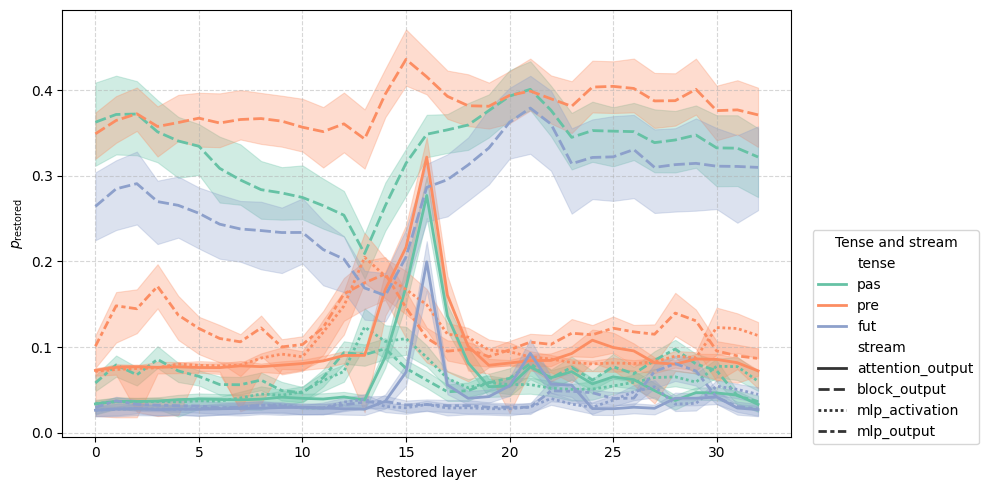

In [130]:
# 1) Fixed category order
tense_order = ['pas', 'pre', 'fut']
df['tense'] = pd.Categorical(df['tense'],
                             categories=tense_order,
                             ordered=True)

# 2) Build a dict that maps each tense to one of Set2’s colors
base_colors = sns.color_palette("Set2", n_colors=len(tense_order))
palette = dict(zip(tense_order, base_colors))

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=agg,
    x="restore_layer",
    y="p_restored_mean",
    hue="tense",
    hue_order=tense_order,
    style="stream",
    palette=palette,              # ← use your dict here
    linewidth=2,

    # 3) Draw a 50%-CI rather than 95% to narrow the band
    errorbar=("ci", 30),

    # 4) Thin / fade the band itself
    err_style="band",             
    err_kws={
        "linewidth": 0.8,         # make the fill’s outline thinner
        "alpha": 0.3              # make the band more transparent
    }
)

plt.xlabel("Restored layer")
plt.ylabel(r"$p_{\mathrm{restored}}$")
plt.legend(title="Tense and stream", bbox_to_anchor=(1.02, 0.5))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()